# Algoritmo Jigsaw
En este notebook vamos a explicar las diferentes clases y métodos que utilizamos para solucionar el puzzle.

Autores: 
- Jordi Hamberg Gallego
- Héctor Sancho Rodríguez

## Clase ``Piece``:

---
```python
class Piece:
    def __init__(self, index):

        df = pd.read_pickle('esquinas_detectadas.pkl')

        self.index = index
        self.contour = df['contorno'][index]
        self.corners = df['esquinas'][index]

        self._sort_corners()
        self.edges = self.generate_edges()

       # Asociamos a cada pieza su imagen por delante y por detras
        back_path = "fotos/segmented_scan_25/back"
        front_path = "fotos/segmented_scan_25/front"
        self.front_img_path = f"{front_path}/{index:02d}.png"
        self.back_img_path = f"{back_path}/{index:02d}.png"
```

---
- Esta es una clase que represente cada una de las piezas del puzzle. Tiene como parámetro el índice en el que se encuentra dentro de la carpeta de fotos.

- Sus variables iniciales son los índices, los contornos y las esquinas, a partir de ello crearemos la variable que contiene las diferentes aristas con los métodos que vamos a crear. 

Ahora vamos creamos dos métodos que nos den una representación trasera y delantera, `display_back` y `display_front`, por si queremos ver la pieza con la que estamos trabajando, con las que simplemente leemos las imagenes con cv2 y las ploteamos en RGB.

---
```python
    def display_back(self):
        plt.imshow(cv.cvtColor(cv.imread(self.back_img_path), cv.COLOR_BGR2RGB))
        plt.show()

    def display_front(self):
        plt.imshow(cv.cvtColor(cv.imread(self.front_img_path), cv.COLOR_BGR2RGB))
        plt.show()
```
---

In [1]:
from jigsaw import Piece

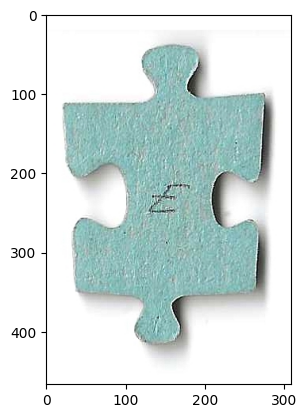

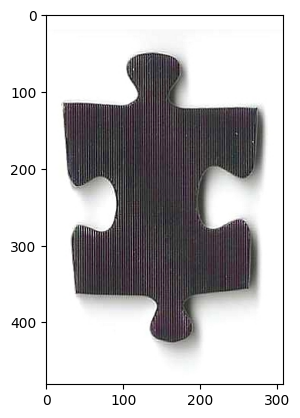

In [4]:
piece = Piece(0)
piece.display_back()
piece.display_front()

Ahora queremos tener cada arista/cara de la pieza por separado para poder hacer el algoritmo que los compare. Para conseguir las aristas necesitamos que las esquinas estén ordenadas de manera contigua para así poder recorrer el contorno, ya que ahora mismo puede que tengamos una pieza cuya lista de esquinas sea [arriba_izq, abajo_der, arriba_der, abajo_izq]. Para ello creamos un método `_sort_corners` que nos ordene en sentido horario o antihorario las piezas:

---
```python    
def _sort_corners(self):
        def angle(corner):
            centroide = np.mean(self.corners, axis=0)
            vector = corner - centroide
            return np.arctan2(vector[1], vector[0])

        self.corners = sorted(self.corners, key=angle)
```
---
Lo que hace esencialmente es calcular el vector que va desde el centroide de la pieza hasta la esquinas y ordenarlas por el ángulo que forman con respecto del eje X. Con esto conseguimos que estén ordenadas en esquinas contiguas.

Una vez tenemos esto, podemos separar cada una de las aristas con el método `generate_edges`:

---
```python
def generate_edges(self):

    edges = []

    for i in range(4):
        c2 = self.corners[i]
        c1 = self.corners[(i + 1) % 4]

        i_c1 = np.where((self.contour == c1).all(axis=1))[0][0]
        i_c2 = np.where((self.contour == c2).all(axis=1))[0][0]

        if i_c1 < i_c2:
            edge_contour = self.contour[i_c1:i_c2 + 1]
        else:
            edge_contour = np.concatenate((self.contour[i_c1:], self.contour[:i_c2 + 1]), axis=0)

        edges.append(Edge(edge_contour, self))

    return edges
```
---
Lo que hacemos con este método es simplemente coger todos los puntos del contorno que se encuentran entre las dos esquinas y guardarlas como una arista en la lista de aristas de la pieza. Cada una de las aristas es un objeto de clase Edge, que vamos a explicar ahora.

In [8]:
import pandas as pd
df = pd.read_pickle('esquinas_detectadas.pkl')
print(f'Antes de ordenar:\n {df['esquinas'][0]}')

Antes de ordenar:
 [[259 349]
 [274 100]
 [ 38 350]
 [ 22 113]]


Vemos que antes de ordenar están como [abajo_derecha, abajo_izquierda, arriba_derecha, arriba_derecha]. Al hacer el borde de abajo_izquierda a arriba_derecha, este cogería el contorno de dos aristas ya que son piezas con esquinas opuestas. Sin embargo, con _sort_corners, nos aseguramos de que estén ordenadas.

In [10]:
piece.corners

[array([ 22, 113], dtype=int32),
 array([274, 100], dtype=int32),
 array([259, 349], dtype=int32),
 array([ 38, 350], dtype=int32)]

Vemos que están [arriba_izquierda, arriba_derecha, abajo_derecha, abajo_izquierda] en el sentido de las agujas del reloj. Ahora podemos aplicar generate_edges, que como vemos nos devuelve los objetos de clase Edge (arista).

In [11]:
piece.generate_edges()

## Clase ``Edge``:

---
```python
class Edge():

    def __init__(self, contour, pieza):
        self.contour = contour
        self.pieza = pieza
        self.kind = self.clasify_kind()  
```

---
- Esta es una clase que represente cada una de las aristas de una pieza del puzzle. Tiene como parámetros el contorno y la pieza.

- Sus variables iniciales son el contorno de la arista y la pieza a la que pertenece (objeto tipo Piece). A partir de estas variables crearemos los métodos que veamos pertinentes para solucionar el algoritmo. 

Primero creamos un método que nos den una representación trasera (porque el algoritmo lo haremos con las partes traseras de las piezas) de la arista, `plot`, por si queremos ver la arista con la que estamos trabajando. Simplemente leemos la imagen de la pieza con cv2, la ploteamos en RGB y resaltamos el contorno de la arista.

---
```python
def plot(self):
        plt.imshow(cv.cvtColor(cv.imread(self.pieza.back_img_path), cv.COLOR_BGR2RGB))
        plt.plot(self.contour[:, 0], self.contour[:, 1])
        c1 = self.contour[0]
        c2 = self.contour[-1]
        plt.plot(c1[0], c1[1], 'ro')
        plt.plot(c2[0], c2[1], 'go')
        plt.show()
```
---
Al plotear, el punto rojo representa la esquina que se encuentra en el primer ìndice del contorno y el punto verde la esquina que se encuetrna en el último índice del contorno. Aquí vemos dos ejemplos de la arista 2 (la de abajo) de la pieza 0 y la arista 0 de la pieza 5 (la de arriba).

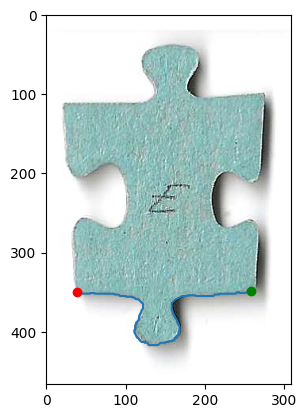

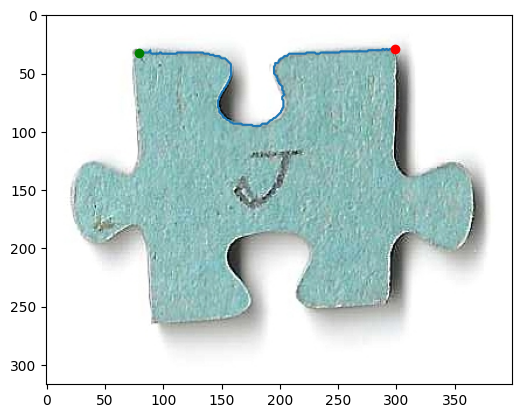

In [12]:
piece = Piece(0)
num = 2
piece.edges[num].plot()
piece = Piece(5)
num = 0
piece.edges[num].plot()

Lo siguiente que queremos hacer es comprobar el tipo al que pertenece la arista, lo haremos con la función `classify_kind`, que nos dice si se trata de una arista saliente (macho), entrante (hembra) o que forma parte del borde del puzzle (plano). Esto lo hacemos porque en el algoritmo solo querremos comparar aristas de tipo opuesto, que son las que encajarían. No tendría sentido comparar una saliente con otra saliente, en la vida real nadie lo haría.

--- 
```python
def clasify_kind(self):

        c1 = self.contour[0]
        c2 = self.contour[-1]
        
        middle_point_edge = self.contour[len(self.contour)//2]
        
        center_line = (c1 + c2) / 2
        
        vector_middle_point_to_center_line = middle_point_edge - center_line
        distance_middle_point_to_center_line = np.linalg.norm(vector_middle_point_to_center_line)
        
        if distance_middle_point_to_center_line < 5:
            return 'plano'
        
        centroide = np.mean(self.pieza.contour, axis=0)
        vector_center_line_to_centroid = centroide - center_line
        
        producto_punto = np.dot(vector_middle_point_to_center_line, vector_center_line_to_centroid)
        if producto_punto > 0:
            return 'hembra'
        else:
            return 'macho'
```
--- 
Lo que hacemos con este método es mirar el punto medio del vector que une los dos extremos y con eso hacer otros dos vectores desde ahí, uno que va hacia el punto que está en el medio del conjunto de puntos del borde; y otro que va hacia el centroide de la pieza.
Primero comprueba:
- Si la distancia entre el punto medio del vector y el punto medio del borde es menor que un umbral, lo considera como que no está lo suficientementel lejos como para ser un saliente o entrante y que se trata de una arista de tipo plano, es decir, que forma parte del borde del puzzle.

Una vez comprobado esto, seguimos teniendo dos vectores con una dirección cada uno. Los multiplicamos con un producto escalar y podemos saber de qué tipo es gracias a lo siguiente:
- Si apuntan a la misma dirección, el producto escalar será positivo y sabremos que es hembra.
- Si apuntan en distinta dirección, el producto escalar será negativo y sabremos que es macho.



Dos ejemplos:

<p style="text-align: center"><img src="fotos\ejemplos\ejemplo_arista_macho.jpg"></p>

Vemos que el vector que va desde el punto medio de la línea que une los dos extremos al punto medio del borde y el vector que va al centroide tienen dirección distinta. Por eso, será clasificado como macho.

In [14]:
piece.edges[0].kind

'macho'

<p style="text-align: center"><img src="fotos\ejemplos\ejemplo_arista_hembra.jpg"></p>

Aquí pasa algo distinto, que el vector que va desde el punto medio de la línea que une los dos extremos al punto medio del borde y el vector que va al centroide tienen la misma dirección. Por eso, será clasificado como hembra.

In [16]:
piece= Piece(0)
piece.edges[1].kind

'hembra'

Para la pieza 0 (E) entonces la lista de tipos sería (en sentido a las agujas del reloj empezando por arriba):

In [15]:
print([edge.kind for edge in piece.edges])

['macho', 'hembra', 'macho', 'hembra']


Una vez tenemos esto vamos a hacer que el contorno de la arista esté recto con respecto al eje X, que empiece desde el punto 0 y que todas apunten hacia arriba, para más tarde poder hacer las comparaciones por similaridad/disimilaridad.
Para ellos creamos el método que tratamos como propiedad `straighten_contour`

---
```python
    @property
    def straighten_contour(self):

        c1 = self.contour[0]
        c2 = self.contour[-1]

        direction = c2 - c1
        angle = np.arctan2(direction[1], direction[0])

        kind = self.kind

        if kind == 'hembra':
            R = np.array([[np.cos(np.pi - angle), -np.sin(np.pi - angle)],
                          [np.sin(np.pi - angle),  np.cos(np.pi - angle)]])
            
            rotated = np.dot(self.contour - c2, R.T)
        else:
            R = np.array([[np.cos(-angle), -np.sin(-angle)],
                          [np.sin(-angle),  np.cos(-angle)]])
        
            rotated = np.dot(self.contour - c1, R.T)
            rotated = rotated[::-1]
        

        return rotated
```
---
Lo que hacemosa quí es mirar el ángulo que forma el vector entre las dos esquinas de la arista con el eje X y aplicar una rotación para que las dos se encuentren en el Y=0. Además restamos c2/c1 para que empiece en (0,0).

Las hembras y los machos la principio apuntaban en direcciones contrarias y se hacía como un flip horizontal, por eso los tratamos con diferentes rotaciones cada una. 

Además, al rotar los machos, el primer punto se encontraba en la esquina derecha y el último en la esquina izquierda; y al rotar las hembras el primer punto se encontraba en la esquina izquierda y el último en la esquina derecha. Esto nos traía problemas a la hora usar nuestra función de disimilaridad, ya que requiere que el orden de los puntos empiece en (0,0) para los dos. Por eso, cambiamos el orden de los puntos en los machos para que vayan también de izquierda a derecha.
  

In [17]:
piece_0_2 = Piece(0)
piece_5_0 = Piece(5)
edge_0_2 = piece_0_2.edges[2]
edge_5_0 = piece_5_0.edges[0]

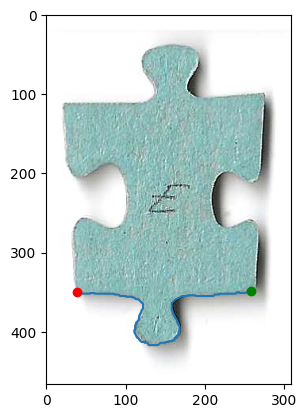

<Figure size 640x480 with 0 Axes>

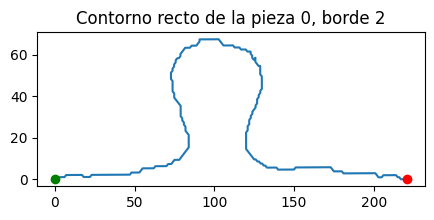

<Figure size 640x480 with 0 Axes>

In [40]:
import matplotlib.pyplot as plt
#ploteamos primero la arista 2 de la pieza 0
edge_0_2.plot()
plt.figure(figsize=(5,2))
contorno_recto_0_2 = edge_0_2.straighten_contour
plt.plot(contorno_recto_0_2[:, 0], contorno_recto_0_2[:, 1])
plt.plot(contorno_recto_0_2[0, 0], contorno_recto_0_2[0, 1], 'ro') 
plt.plot(contorno_recto_0_2[-1, 0], contorno_recto_0_2[-1, 1], 'go')
plt.title('Contorno recto de la pieza 0, borde 2')
plt.figure()

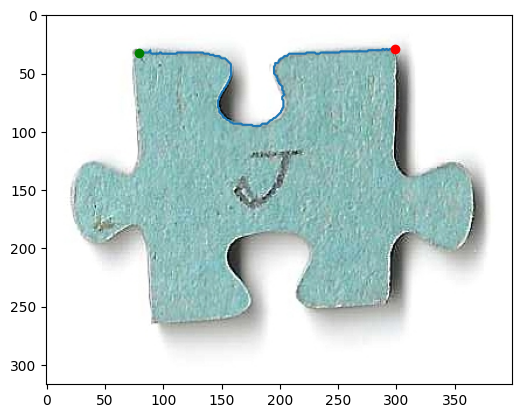

<Figure size 640x480 with 0 Axes>

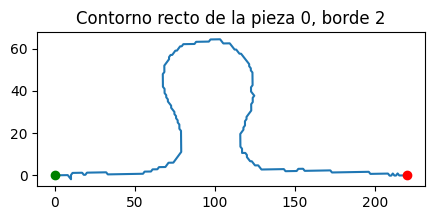

<Figure size 640x480 with 0 Axes>

In [39]:
edge_5_0.plot()
plt.figure(figsize=(5,2))
contorno_recto_5_0 = edge_5_0.straighten_contour
plt.plot(contorno_recto_5_0[:, 0], contorno_recto_5_0[:, 1])
plt.plot(contorno_recto_5_0[0, 0], contorno_recto_5_0[0, 1], 'ro') 
plt.plot(contorno_recto_5_0[-1, 0], contorno_recto_5_0[-1, 1], 'go')
plt.title('Contorno recto de la pieza 0, borde 2')
plt.figure()

Una vez tenemos esto, 

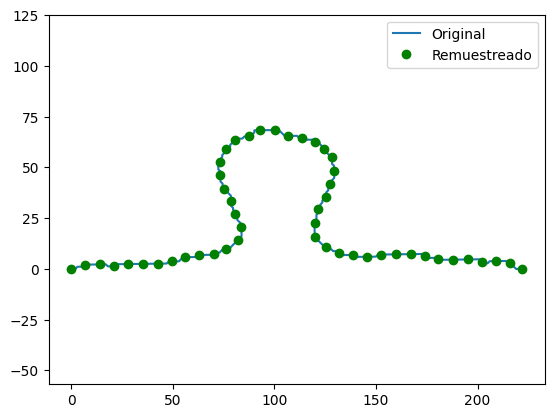

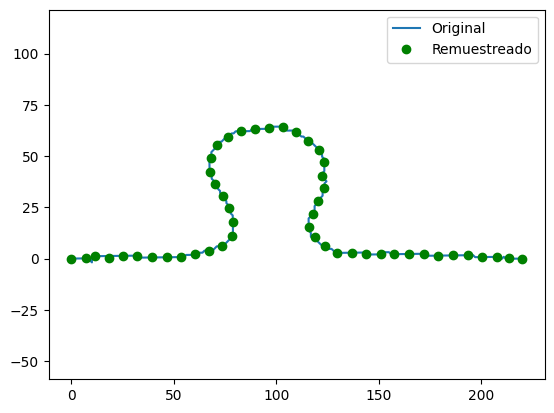

(array([220.02044678, 213.40841295, 207.53292589, 200.26054425,
        193.38870089, 186.11632066, 178.84394042, 171.97209768,
        164.69971526, 157.42733283, 150.98329779, 143.7890077 ,
        136.83907669, 129.56669748, 123.61999998, 118.81198741,
        115.79950712, 117.7114518 , 120.1938813 , 123.13300274,
        122.46430764, 123.37069902, 120.75402217, 115.27123711,
        109.76263197, 103.41725791,  96.52229886,  89.41330971,
         82.56874335,  76.46549984,  71.25227486,  68.33478096,
         67.42839195,  70.20961417,  74.01598544,  77.11930866,
         78.76192068,  78.61168957,  73.37225467,  66.95549921,
         60.36993994,  53.69417439,  46.42179339,  39.14941238,
         32.19424531,  25.00519214,  18.16062263,  11.28878252,
          7.27238069,   0.        ]),
 array([-1.31006317e-14,  3.02575355e-01,  8.29808497e-01,  7.30639637e-01,
         1.63702576e+00,  1.53785688e+00,  1.43868800e+00,  2.34507412e+00,
         2.24590519e+00,  2.14673627e+00, 

In [7]:
edge_0_2.resample_contour_uniform(n_samples=50, plot=True)
edge_5_0.resample_contour_uniform(n_samples=50, plot=True)

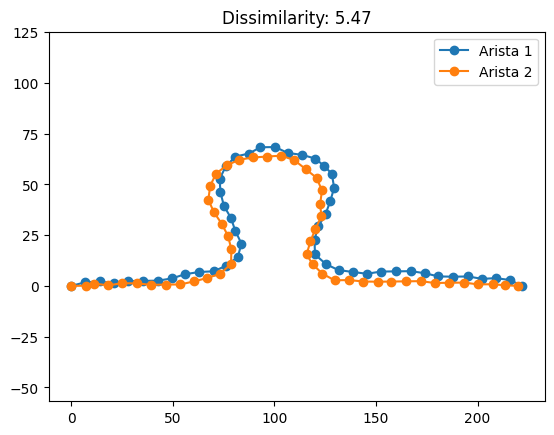

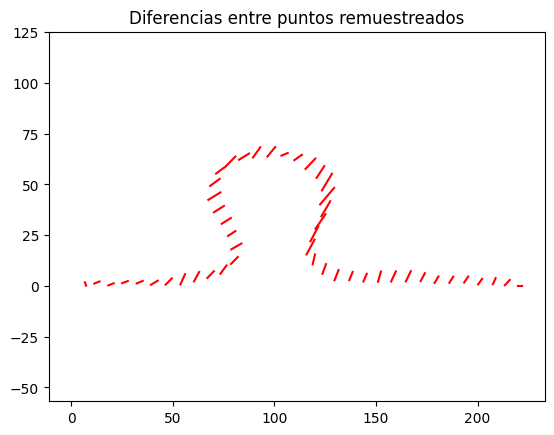

np.float64(5.474629971241544)

In [8]:
edge_0_2.dissimilarity(edge_5_0, plot=True)

In [19]:
import numpy as np
from itertools import product

c1 = 0.5  # Coeficiente para la diferencia de longitudes
n_samples = 50  # Número de muestras para el remuestreo

test_edge = Piece(8).edges[3]

def disimilarity_tests(i_piece, i_edge, c1=c1, n_samples=n_samples):
    piece = Piece(i_piece)
    edge = piece.edges[i_edge]
    return test_edge.dissimilarity(edge, c1=c1, n_samples=n_samples, plot=False)

# Generar todas las combinaciones (pieza, arista)
piece_edge_combinations = list(product(range(25), range(4)))

# Ordenar por dissimilarity (de menor a mayor)
piece_edge_combinations_sorted = sorted(
    piece_edge_combinations, 
    key=lambda x: disimilarity_tests(x[0], x[1], c1=c1, n_samples=n_samples)
)

for i_piece, i_edge in piece_edge_combinations_sorted:
    disim = disimilarity_tests(i_piece, i_edge, c1=c1, n_samples=n_samples)
    print(f"Piece {i_piece} Edge {i_edge} -> Dissimilarity: {disim}")

Piece 9 Edge 1 -> Dissimilarity: 4.345923483175545
Piece 24 Edge 0 -> Dissimilarity: 6.262034852830051
Piece 21 Edge 0 -> Dissimilarity: 7.9121636123862285
Piece 11 Edge 0 -> Dissimilarity: 10.257633149036014
Piece 23 Edge 2 -> Dissimilarity: 10.391811075319813
Piece 21 Edge 3 -> Dissimilarity: 12.091210513029504
Piece 23 Edge 0 -> Dissimilarity: 12.310156161396861
Piece 7 Edge 0 -> Dissimilarity: 12.769003333725808
Piece 11 Edge 2 -> Dissimilarity: 13.053010439810425
Piece 1 Edge 0 -> Dissimilarity: 13.343251465177623
Piece 1 Edge 2 -> Dissimilarity: 15.05043170345369
Piece 0 Edge 1 -> Dissimilarity: 15.404422340225706
Piece 10 Edge 3 -> Dissimilarity: 15.529720549184669
Piece 24 Edge 1 -> Dissimilarity: 16.21332278790797
Piece 4 Edge 0 -> Dissimilarity: 16.88332221173752
Piece 7 Edge 2 -> Dissimilarity: 17.01385865832124
Piece 2 Edge 0 -> Dissimilarity: 17.33823957725857
Piece 6 Edge 3 -> Dissimilarity: 18.671039203630414
Piece 0 Edge 3 -> Dissimilarity: 19.963426814544217
Piece 9 Ed

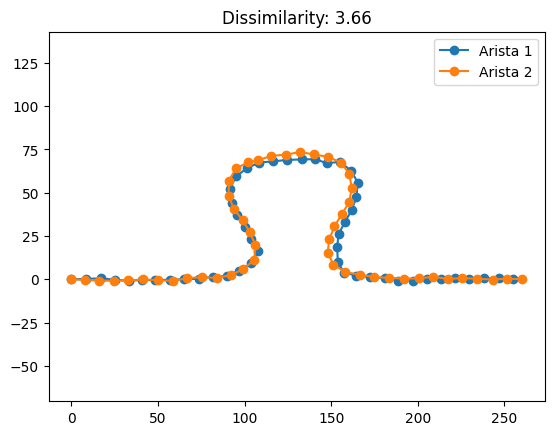

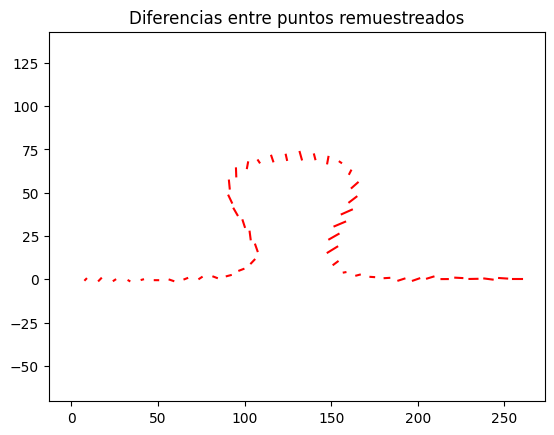

np.float64(3.6623659551981786)

In [21]:
edge_1 = Piece(8).edges[3]
edge_2 = Piece(24).edges[0]

edge_1.dissimilarity(edge_2, plot=True)

In [11]:
edge_0_2.straighten_contour

array([[ 2.22020269e+02,  0.00000000e+00],
       [ 2.19020543e+02, -4.05368394e-02],
       [ 2.15980280e+02,  2.91865244e+00],
       [ 2.14980372e+02,  2.90514016e+00],
       [ 2.13966951e+02,  3.89153658e+00],
       [ 2.05967681e+02,  3.78343834e+00],
       [ 2.04981285e+02,  2.77001736e+00],
       [ 2.02981467e+02,  2.74299280e+00],
       [ 2.00954625e+02,  4.71578565e+00],
       [ 1.80956451e+02,  4.44554005e+00],
       [ 1.79943030e+02,  5.43193648e+00],
       [ 1.74943487e+02,  5.36437508e+00],
       [ 1.72916645e+02,  7.33716793e+00],
       [ 1.50918653e+02,  7.03989777e+00],
       [ 1.49932257e+02,  6.02647679e+00],
       [ 1.39933170e+02,  5.89135399e+00],
       [ 1.38919749e+02,  6.87775042e+00],
       [ 1.32920296e+02,  6.79667674e+00],
       [ 1.31906875e+02,  7.78307316e+00],
       [ 1.30906967e+02,  7.76956088e+00],
       [ 1.29893546e+02,  8.75595731e+00],
       [ 1.28893637e+02,  8.74244503e+00],
       [ 1.27880216e+02,  9.72884145e+00],
       [ 1.

TypeError: 'str' object is not callable

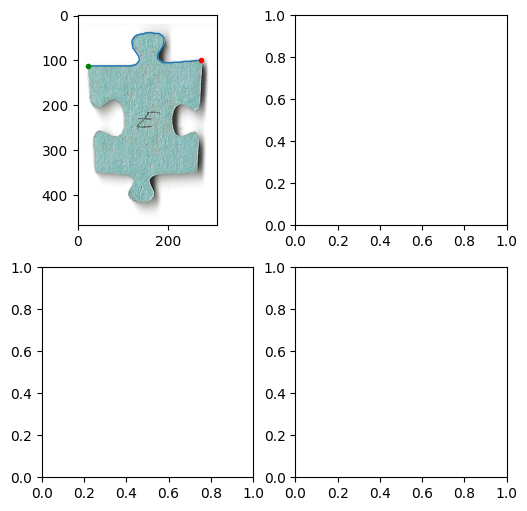

In [12]:
import matplotlib.pyplot as plt
import cv2 as cv

# Plot all pieces; create/close a fresh figure per piece so Jupyter renders each one
for i in range(20):
    fig, axs = plt.subplots(2, 2, figsize=(6, 6))
    axs = axs.ravel()

    piece = Piece(i)
    img = cv.cvtColor(cv.imread(piece.back_img_path), cv.COLOR_BGR2RGB)

    for j in range(4):
        ax = axs[j]
        ax.clear()

        ax.imshow(img)

        contour = piece.edges[j].contour
        ax.plot(contour[:, 0], contour[:, 1], linewidth=1)

        c1, c2 = contour[0], contour[-1]
        ax.plot(c1[0], c1[1], "ro", markersize=3)
        ax.plot(c2[0], c2[1], "go", markersize=3)

        ax.set_title(f"Piece {i} / Edge {j} / {piece.edges[j].kind()}")
        ax.axis("off")

    fig.tight_layout()
    plt.show()
    plt.close(fig)
        
    
